In [10]:
#Importing libraries
from PIL import Image
import os #For file operations
import random
import matplotlib.pyplot as plt #To display the images
import shutil #To move images and labels
import cv2 #To use in Data Augmentation

### Roboflow Images

We have downloaded the pistols dataset from Robolow to use during training along with the dataset we have collected.

In [31]:
rbflw_images = os.listdir("export/images/")
print(f"Number of Images: {len(rbflw_images)}")

Number of Images: 2971


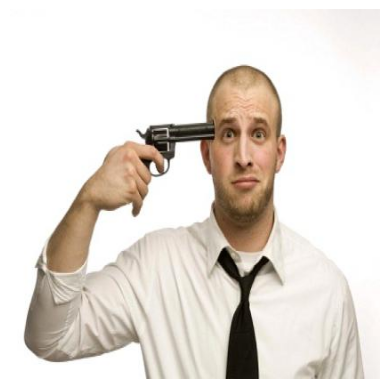

Size: (416, 416)


In [43]:
random_image = random.choice(rbflw_images) #Selecting a random image
rbflw_image_path = os.path.join("export/images/", random_image) #Path of the image
rbflw_image = Image.open(rbflw_image_path)

plt.imshow(rbflw_image)
plt.axis("off")
plt.show()
print(f"Size: {rbflw_image.size}")

Images inside this dataset are shaped 416x416, and all of them have corresponding labels that include pistols" bounding box coordinates.

In [44]:
label_file = os.path.splitext(random_image)[0] + ".txt"
rbflw_label_path = os.path.join("export/labels/", label_file)

with open(rbflw_label_path, "r") as label_file:
        label_content = label_file.read()
        print(f"Label Content:\n{label_content}")

Label Content:
0 0.44318181818181823 0.3758741258741259 0.21969696969696972 0.16433566433566432


### Screenshots

We have collected 200 images that include a pistol by taking screenshots from many movies.

In [3]:
screenshots = os.listdir("screenshots")
print(f"Number of Images: {len(screenshots)}")

Number of Images: 200


We have tried to take the screenshots in a way that the captured images will have 1:1 ratio, since the YOLOv8 model we are going to use requires that ratio.

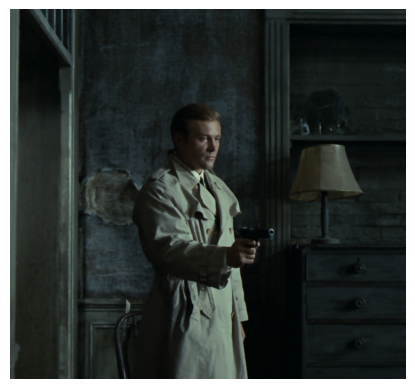

Size: (1077, 1007)


In [46]:
random_ss = random.choice(screenshots) 
image_path = os.path.join("screenshots", random_ss)
image = Image.open(image_path)

plt.imshow(image)
plt.axis("off")
plt.show()
print(f"Size: {image.size}")

## Resizing the Screenshots

Images we have downloaded from Roboflow had 416x416 size. We need to resize our screenshots before labeling them.

In [ ]:
input_folder = "screenshots"
output_folder = "resized_screenshots" #Folder to store resized, 416x416 screenshots
target_size = (416, 416)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

image_files = [f for f in os.listdir(input_folder) if f.endswith((".png"))] #All the screenshots

for i, image_file in enumerate(image_files):
    input_path = os.path.join(input_folder, image_file)
    
    output_name = str(i + 1) + ".png" #Resized images will have sequential name
    output_path = os.path.join(output_folder, output_name)

    img = Image.open(input_path)

    img_resized = img.resize(target_size, resample=Image.NEAREST) #Resizing the image with stretching

    img_resized.save(output_path) #Saving the resized image to resized_screenshots folder

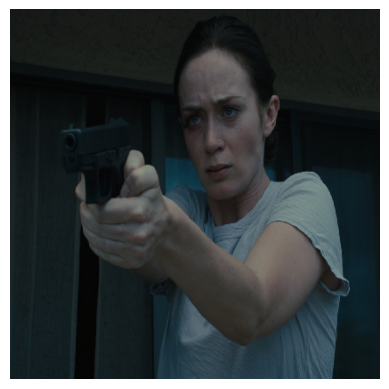

Size: (416, 416)


In [81]:
resized_ss = os.listdir("resized_screenshots")
random_resized_ss = random.choice(resized_ss) 
resized_image_path = os.path.join("resized_screenshots", random_resized_ss)
resized_image = Image.open(resized_image_path)

plt.imshow(resized_image)
plt.axis("off")
plt.show()
print(f"Size: {resized_image.size}")

After resizing the screenshots, we have labeled them with LabelImg, and saved the labels inside "labels" folder.

## Train, Validation, Test Split

### Test Images

We will save 80 of the screenshots for testing

In [2]:
random.seed(42)

test_folder = os.path.join("data", "test")
os.makedirs(test_folder, exist_ok=True)

test_image_folder = os.path.join(test_folder, "images")
test_label_folder = os.path.join(test_folder, "labels")
os.makedirs(test_image_folder, exist_ok=True)
os.makedirs(test_label_folder, exist_ok=True)

resized_screenshots_folder = "resized_screenshots"
all_image_files = [f for f in os.listdir(resized_screenshots_folder) if f.endswith((".png"))] #Getting all the resized screenshots

test_image_files = random.sample(all_image_files, 80) #Randomly selecting 80 of them for testing


In [12]:
#Copying the selected images and corresponding labels to the test folder
for image_file in test_image_files:
    label_file = image_file.replace(".png", ".txt") #Label of the image

    #Copying the images and their labels to test folder
    shutil.copy(os.path.join(resized_screenshots_folder, image_file), os.path.join(test_image_folder, image_file))
    shutil.copy(os.path.join("labels", label_file), os.path.join(test_label_folder, label_file))

### Train and Validation Images

In [3]:
random.seed(42)

train_folder = os.path.join("data", "train") #Folder to store train set
valid_folder = os.path.join("data", "valid") #Folder to store validation set

os.makedirs(os.path.join(train_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(train_folder, "labels"), exist_ok=True)
os.makedirs(os.path.join(valid_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(valid_folder, "labels"), exist_ok=True)

export_image_folder = os.path.join("export", "images") #Folder that stores the images downloaded from roboflow
export_images = [f for f in os.listdir(export_image_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

export_label_folder = os.path.join("export", "labels")
export_labels = [f for f in os.listdir(export_label_folder) if f.endswith(".txt")]

all_resized_screenshots = [f for f in os.listdir(resized_screenshots_folder) if f.endswith((".png"))]

test_image_files = [f.replace(".txt", ".png") for f in os.listdir(os.path.join(test_folder, "labels"))] #Test images to exclude in training and validation

remaining_resized_screenshots = [f for f in all_resized_screenshots if f not in test_image_files] #Resized screenshots which were not copied into test

all_images = export_images + remaining_resized_screenshots #Training and validation images will consist of all the images downloaded from roboflow and resized images that were not used in test

num_train_images = int(0.8 * len(all_images)) #Choosing 0.8 : 0.2 ratio for training and validation sets
train_image_files = random.sample(all_images, num_train_images)
valid_image_files = [f for f in all_images if f not in train_image_files]

In [14]:
#Copying the training images, and their labels, inside train folder.
for image_file in train_image_files:
    label_file = image_file.replace(".png", ".txt").replace(".jpg", ".txt").replace(".jpeg", ".txt")
    dst_image = os.path.join(train_folder, "images", image_file)
    dst_label = os.path.join(train_folder, "labels", label_file)
    
    if image_file in export_images:
        src_image = os.path.join(export_image_folder, image_file)
        src_label = os.path.join(export_label_folder, label_file)
        
    else:
        src_image = os.path.join(resized_screenshots_folder, image_file)
        src_label = os.path.join("labels", label_file)

    shutil.copy(src_image, dst_image)
    shutil.copy(src_label, dst_label)

#Copying the validation images, and their labels, inside valid folder.
for image_file in valid_image_files:
    label_file = image_file.replace(".png", ".txt").replace(".jpg", ".txt").replace(".jpeg", ".txt")
    dst_image = os.path.join(valid_folder, "images", image_file)
    dst_label = os.path.join(valid_folder, "labels", label_file)
    
    if image_file in export_images:
        src_image = os.path.join(export_image_folder, image_file)
        src_label = os.path.join(export_label_folder, label_file)
        
    else:
        src_image = os.path.join(resized_screenshots_folder, image_file)
        src_label = os.path.join("labels", label_file)

    shutil.copy(src_image, dst_image)
    shutil.copy(src_label, dst_label)

## Data Augmentation

After noticing that our model was not detecting the pistols which are out of focus, we decided to add blurred images to the training dataset to make our model more robust.

In [5]:
blur_images_folder = "blur_images" #Folder to store blurred images
os.makedirs(os.path.join(blur_images_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(blur_images_folder, "labels"), exist_ok=True)

random_train_images = random.sample(train_image_files, 200) #Selecting 200 train images to blur

for image_file in random_train_images:
    label_file = image_file.replace(".png", ".txt").replace(".jpg", ".txt").replace(".jpeg", ".txt")
    dst_image = os.path.join(blur_images_folder, "images", "blur" + image_file)
    dst_label = os.path.join(blur_images_folder, "labels", "blur" + label_file)

    if "armas" in image_file: 
        src_image = os.path.join(export_image_folder, image_file)
        src_label = os.path.join(export_label_folder, label_file)
    else:
        src_image = os.path.join(resized_screenshots_folder, image_file)
        src_label = os.path.join("labels", label_file)

    original_image = cv2.imread(src_image)

    blurred_image = cv2.GaussianBlur(original_image, (25, 25), 0) #Applying blur

    cv2.imwrite(dst_image, blurred_image)

    shutil.copy(src_label, dst_label)
